In [89]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize
from sklearn.preprocessing import StandardScaler 
from cellregmap import run_interaction, estimate_betas

# INPUT AND OUTPUT
# Input: gene, test_eqtl_file, sample_mapping_file, genotype_file, kinship_file, phenotype_file, cell_context_file

In [61]:
test_eqtl_file = "/project2/gilad/jpopp/ebQTL/results/cellregmap_eqtl_calling/eb_cellid/pseudobulk_tmm/basic/all_genes_merged.mash-signif.fasttopics_10topics.cellregmap.sighits.tsv"
sample_mapping_file = "/project2/gilad/jpopp/ebQTL/data/cellregmap/pseudocell_metadata.tsv"
genotype_file = "/project2/gilad/jpopp/ebQTL/data/genotypes/yri_maf0.1_all.hg38.bed"
kinship_file = "/project2/gilad/jpopp/ebQTL/data/genotypes/yri_kinship.tsv"
phenotype_file = "/project2/gilad/jpopp/ebQTL/data/single_cell_objects/eb_pseudocells_normalized.nc"
cell_context_file = "/project2/gilad/jpopp/ebQTL/results/fast_topics/fasttopics_10topics_loadings.tsv"

g = "AS3MT"
qtl_snp = "rs11191419"

In [4]:
# ############################################
# ############### Gene file ##################
# ############################################


######################################
#####Filter on specific gene-SNP pairs
all_tests = pd.read_csv(test_eqtl_file, sep="\t")

In [5]:
all_tests

,EB_HGNC,EB_VARIANT_ID,P_CELLREGMAP,P_BONF,q
0,ABHD4,rs5742787,4.563214e-06,1.277700e-04,8.806870e-03
1,ACRV1,rs558004,1.329434e-06,5.450680e-05,4.469558e-03
2,ADGRA3,rs2875040,1.205048e-04,2.410095e-04,1.508212e-02
3,ADGRF3,rs5016767,4.890310e-04,9.780620e-04,4.388361e-02
4,ADH4,rs10017466,1.075731e-07,3.657486e-06,6.442593e-04
...,...,...,...,...,...
133,TTC4,rs12067395,9.301301e-10,1.209169e-07,3.833872e-05
134,VRK3,rs10405466,3.808532e-06,1.355837e-03,5.481715e-02
135,XRRA1,rs78022531,1.145142e-06,6.870850e-06,9.902353e-04
136,ZNF232,rs73976308,8.798941e-06,1.055873e-04,7.384899e-03


In [62]:
############################################
########## Sample mapping file #############
############################################

## this file will map pseudocells to donors 
## it will also only include donors we have single-cell data for
sample_mapping = pd.read_csv(sample_mapping_file, sep="\t").sort_values(by=['donor_id', 'pseudocell'])

## donor_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## cell are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)

## extract unique individuals
donors = sample_mapping["donor_id"].unique()
print("Number of unique donors: {}".format(len(donors)))

############################################
############# Kinship matrix ###############
############################################

## read in GRM (genotype relationship matrix; kinship matrix)
#kinship_file=input_files_dir+"kinship_file.csv"
K = pd.read_csv(kinship_file, sep = "\t", index_col = 0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

# Make the dataframe as DataArray
K = xr.DataArray(K.values, dims=["donor_0", "donor_1"], coords={"donor_0": K.columns, "donor_1": K.index})
K = K.sortby("donor_0").sortby("donor_1")

# Find the shared donors between kinship and expression data
donors = sorted(set(list(K.donor_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

# subset to relevant donors
K = K.sel(donor_0=donors, donor_1=donors)
assert all(K.donor_0 == donors)
assert all(K.donor_1 == donors)

# Decompose such as K = hK @ hK.T
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.donor_0.values})
assert all(hK.sample.values == K.donor_0.values)

del K

############################################
##### expand from donors to cells ##########

# Expand hK from donors to cells
hK_expanded = hK.sel(sample=sample_mapping["donor_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["donor_id"].values)


#####################################
############ Phenotypes #############
#####################################

# Phenotype (pseudocell expression)
phenotype = xr.open_dataarray(phenotype_file, autoclose=True)
assert all(phenotype.pseudo_cell.values == sample_mapping["pseudocell"].values)
######################################
########## Cell contexts #############
######################################

# cellular environments
C = pd.read_csv(cell_context_file, index_col = 0, sep = "\t")

# filter to the more interpretable topics
C = C[['k1','k2', 'k4','k5','k6', 'k7', 'k8', 'k10']]

C = xr.DataArray(C.values, dims=["pseudocell", "topic"], coords={"pseudocell": C.index.values, "topic": C.columns.values})
assert all(C.pseudocell.values == sample_mapping["pseudocell"].values)

# normalize cell contexts
scaler = StandardScaler()
scaler.fit(C.values)
C.values = scaler.transform(C.values)

######################################
############ Covariates ##############
######################################

cov = sample_mapping.drop(columns='donor_id').set_index('pseudocell')
cov['intercept'] = 1

Number of unique donors: 51
Number of donors after kinship intersection: 51


In [63]:
#####################################
############ Genotypes ##############
#####################################

## read in genotype file (plink format)
#plink_file = snakemake_input[1]
G = read_plink1_bin(genotype_file)
# Select snps appearing for that gene
test_snps = all_tests[all_tests['EB_HGNC']==g]['EB_VARIANT_ID'].unique()

G_expanded = G[:,G['snp'].isin(test_snps)].sel(sample=sample_mapping["donor_id"].values)
assert all(hK_expanded.sample.values == G_expanded.sample.values)

print("G_tested shape is {}".format(G_expanded.shape))

######################################
############# Run CRM ################
######################################
#For each gene on specific chromosome

""" Input list: 
    y: n x 1 (only one gene tested at a time)
    W: n x c, where c is the number of fixed effect covariates (e.g., age, sex..)
    C: n x k, where k is the number of contexts to test for interactions
    G: n x s, where s is the number of SNPs to be tested for a given gene
    hK: n x p, where p is the number of individuals, decomposition of the n x n kinship matrix K
"""

# expression for each gene
y = phenotype.sel(gene=g)
y = quantile_gaussianize(y)
y = y.values.reshape(y.shape[0],1)

W = cov.values
C_val = C.values
G_val = G_expanded.values
hK_val = hK_expanded.values

print("Running for gene {}".format(g))

Mapping files: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


G_tested shape is (17913, 1)
Running for gene AS3MT


In [40]:
betas = pd.read_csv("/project2/gilad/jpopp/ebQTL/results/cellregmap_eqtl_calling/eb_cellid/pseudobulk_tmm/basic/all_genes_merged.mash-signif.fasttopics_10topics.cellregmap.betas.tsv", sep="\t")

In [64]:
exp = pd.DataFrame({'PSEUDOCELL': phenotype.pseudo_cell.values,
             'EXPRESSION': phenotype.sel(gene=g).values})

In [65]:
genotype = pd.DataFrame({'PSEUDOCELL': sample_mapping.pseudocell.values,
                         'GENOTYPE': G_expanded.values[:, 0]})

In [67]:
qtl = 'AS3MT_rs11191419'
effect_viz = betas[['PSEUDOCELL', qtl]].merge(exp, on='PSEUDOCELL').merge(genotype, on='PSEUDOCELL')

,PSEUDOCELL,AS3MT_rs11191419,EXPRESSION,GENOTYPE
0,NA18486_11/12/2020_0,-0.437731,2.385526,1.0
1,NA18486_11/12/2020_1,-0.441930,2.027942,1.0
2,NA18486_11/12/2020_10,-0.409885,1.994119,1.0
3,NA18486_11/12/2020_100,-0.184498,2.119082,1.0
4,NA18486_11/12/2020_101,0.098320,3.018047,1.0
...,...,...,...,...
17908,NA19257_12/9/2020_95,0.162340,2.838558,2.0
17909,NA19257_12/9/2020_96,0.145376,1.835546,2.0
17910,NA19257_12/9/2020_97,0.191059,3.475495,2.0
17911,NA19257_12/9/2020_98,0.167050,3.215921,2.0


Load topic loading data

In [127]:
loadings = pd.read_csv("/project2/gilad/jpopp/ebQTL/results/fast_topics/fasttopics_10topics_loadings.tsv", sep="\t")

In [128]:
crm_loadings = loadings[['pseudocell', 'k1','k2', 'k4','k5','k6', 'k7', 'k8', 'k10']]

In [154]:
all_loadings_df = loadings.merge(effect_viz[['PSEUDOCELL', f'{g}_{qtl_snp}']], left_on='pseudocell', right_on='PSEUDOCELL').drop(columns='pseudocell').set_index("PSEUDOCELL").sort_values(f'{g}_{qtl_snp}')
crm_loadings_df = crm_loadings.merge(effect_viz[['PSEUDOCELL', f'{g}_{qtl_snp}']], left_on='pseudocell', right_on='PSEUDOCELL').drop(columns='pseudocell').set_index("PSEUDOCELL").sort_values(f'{g}_{qtl_snp}')

In [198]:
big_df = crm_loadings_df.iloc[:1000].reset_index().drop(columns=f'{g}_{qtl_snp}')

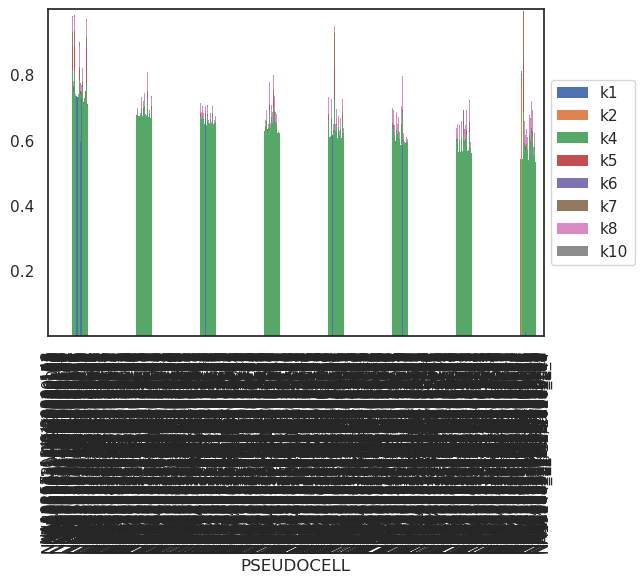

In [200]:
sns.set(style='white')
big_df.plot.bar(x='PSEUDOCELL', stacked=True, edgecolor='none', linewidth=0, width=0.25)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.subplots_adjust(bottom=0.2)

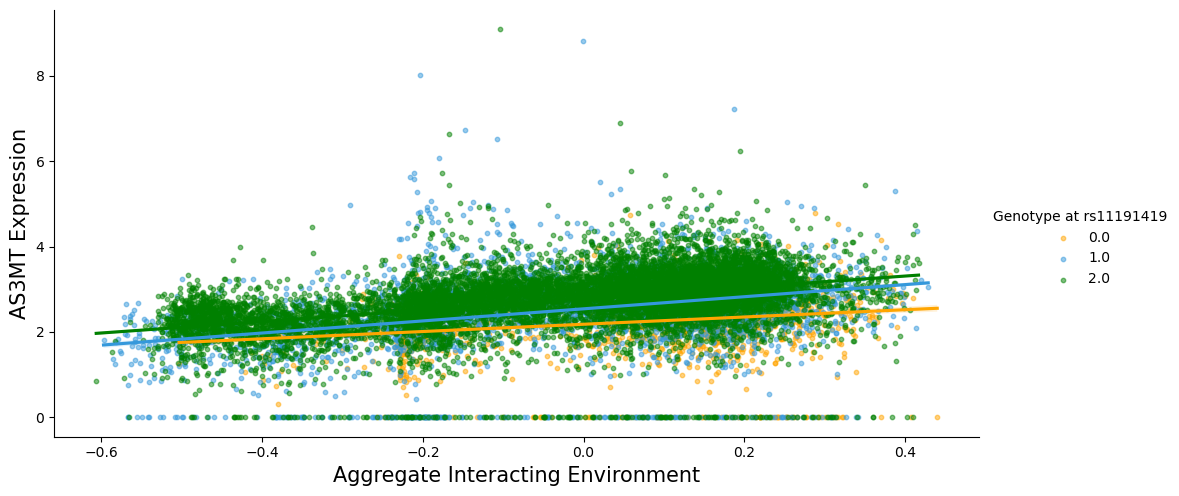

In [70]:
%matplotlib inline

# fig, ax = plt.subplots()

flatui = ["orange", "#3498db", "green"]
sns.set_palette(flatui)

p=sns.lmplot(data = effect_viz, 
             x = qtl, 
             y = "EXPRESSION",
             # x_bins=20,x_ci=99,
             hue = "GENOTYPE",
             legend = False,
             scatter_kws = {"alpha": 0.5, "s":10},
             height=5, aspect=2,truncate = True)

p.set_xlabels("Aggregate Interacting Environment",size=15)
p.set_ylabels(f"{g} Expression",size=15)
p.set().add_legend(title=f'Genotype at {qtl_snp}')


plt.show()

In [ ]:
ax = p.ax
divider = make_axes_locatable(ax)

ax1 = divider.append_axes("top", size="20%", pad=0.05)
C_sorted.plot.area(stacked=True,linewidth=0, colormap="tab10",ax=ax1)
ax1.xaxis.set_visible(False)
ax1.legend(loc ="upper center", prop={'size': 6}, ncol=len(C_sorted.columns))



In [38]:
effects = betas[['pseudocell', 'GSAP_rs9641220']]

type: "['pseudocell'] not in index"

In [57]:
betas[1][0, :, 0].shape

(17913,)

In [58]:
beta_gxc_df = pd.DataFrame({'PSEUDOCELL': phenotype.pseudo_cell.values,
                            'BETA_GXC': betas[1][0, :, 0]})
beta_gxc_df['EB_HGNC'] = g
beta_gxc_df['EB_VARIANT_ID'] = test_snps[0]
beta_gxc_df['BETA_G'] = betas[0][0]

In [60]:
beta_gxc_df

,PSEUDOCELL,BETA_GXC,EB_HGNC,EB_VARIANT_ID,BETA_G
0,NA18486_11/12/2020_0,0.271532,ABHD4,rs5742787,0.126309
1,NA18486_11/12/2020_1,0.273654,ABHD4,rs5742787,0.126309
2,NA18486_11/12/2020_10,0.247547,ABHD4,rs5742787,0.126309
3,NA18486_11/12/2020_100,-0.004193,ABHD4,rs5742787,0.126309
4,NA18486_11/12/2020_101,-0.143878,ABHD4,rs5742787,0.126309
...,...,...,...,...,...
17908,NA19257_12/9/2020_95,0.005670,ABHD4,rs5742787,0.126309
17909,NA19257_12/9/2020_96,-0.006132,ABHD4,rs5742787,0.126309
17910,NA19257_12/9/2020_97,-0.031773,ABHD4,rs5742787,0.126309
17911,NA19257_12/9/2020_98,-0.001698,ABHD4,rs5742787,0.126309


In [40]:
.to_csv(gxc_loc, sep="\t", index=False)

,pseudocell,beta_gxc
0,NA18486_11/12/2020_0,0.271532
1,NA18486_11/12/2020_1,0.273654
2,NA18486_11/12/2020_10,0.247547
3,NA18486_11/12/2020_100,-0.004193
4,NA18486_11/12/2020_101,-0.143878
...,...,...
17908,NA19257_12/9/2020_95,0.005670
17909,NA19257_12/9/2020_96,-0.006132
17910,NA19257_12/9/2020_97,-0.031773
17911,NA19257_12/9/2020_98,-0.001698


In [42]:
beta_G

array([0.12630859])

In [ ]:
# run interaction test using CellRegMap
pvals = run_interaction(y=y, W=W, G=G_val, E=C_val, hK=hK_val)

pv = pd.DataFrame({"EB_HGNC":[g for _ in test_snps],
                  "EB_VARIANT_ID":test_snps,
                  "P_CELLREGMAP":pvals[0]})

pv.to_csv(output_loc, sep="\t", header=False, index=False)


# Adapted from https://github.com/annacuomo/CellRegMap_analyses/blob/df01d14de6813d2d7e9f701313af608336b841e5/endodiff/usage/scripts/association_test_for_one_gene.py#L103